In [1]:
from __future__ import print_function, division
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random
from scipy.io import loadmat

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import WeightedRandomSampler

from PIL import Image
from skimage import io

import time
import utils
import torch
import torch.utils.data
import torchvision

seed = 10
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

ModuleNotFoundError: No module named 'torch'

In [3]:
from utils import Load_Images

In [4]:

root_dir = "data/cars_train/"
car_annotations_path = "data/devkit/cars_train_annos.mat"
car_metadata_path = "data/devkit/cars_meta.mat"

#Load Meta Data
meta_data = loadmat(car_metadata_path)
meta_data = np.concatenate(meta_data["class_names"][0])

nb_classes = len(meta_data)

dataset = Load_Images(root_dir = root_dir, annotations_path=car_annotations_path, seed=seed, train_split=0.8)

In [24]:
class car_dataset(Dataset):
    
    def __init__(self, files, root_dir, meta_data, image_transform=None):
        
        self.root_dir = root_dir
        self.image_transform = image_transform
        
        #image file names
        self.image_files = [file[-1][0] for file in files]
        
        #Class ID
        #id needs to be adjusted by 1, for pytorch NLLosss 
        self.id = [file[-2][0] - 1 for file in files]
        
        #Class Name
        self.class_name = [meta_data[file[-2][0] - 1][0] for file in files]
        
        #Get Car Year
        self.carYear, self.carYear_ID

        #Get Car Maker
        
        #Get Car Type
    def __len__(self):
        return len(self.id)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        img = Image.open(img_path)
        
        if self.image_transform:
            img = self.image_transform(img)
        
        target = torch.from_numpy(np.array(self.id[idx]))[0]

        sample = {'Image':img, 'class_ID':target, "class_name":self.class_name[idx]}
        
        return sample

In [37]:
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
    """

    def __init__(self, dataset, class_type):
                      
        self.indices = list(range(len(dataset)))
        
        self.num_samples = len(self.indices) 
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx, class_type)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx, class_type)] for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx, class_type):
        return dataset[idx][class_type].item()
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
                self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [39]:
#Training Weighted Random Sampler
targets = [i[-2][0][0] for i in dataset["training"]]
class_sample_counts=[len(np.where(targets == t)[0]) for t in np.unique(targets)]
weight = 1. / np.array(class_sample_counts)
samples_weight = np.array([weight[t-1] for t in targets])
samples_weight = torch.from_numpy(samples_weight)
samples_weight = samples_weight.double()
training_sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=False)

#batch size
bs = 15

image_transformers = {'train': transforms.Compose([transforms.Resize((244,244)),
                                                   transforms.RandomRotation(degrees=50),
                                                   transforms.RandomHorizontalFlip(0.8),
                                                   transforms.ColorJitter(brightness=0.8, contrast=0.8),
                                                   transforms.
                                                   transforms.ToTensor(),
                                                   transforms.Normalize([0.485, 0.456, 0.406],
                                                                        [0.229, 0.224, 0.225])
                                                  ]),
                      'validation': transforms.Compose([transforms.Resize((244,244)),
                                                       transforms.ToTensor(),
                                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                                            [0.229, 0.224, 0.225])
                                                       ])
                     }

#
training_data = car_dataset(dataset["training"],
                            root_dir = root_dir,
                            meta_data = meta_data,
                            image_transform = image_transformers["train"]
                           )
train_loader = torch.utils.data.DataLoader(training_data, batch_size=bs, 
                                           sampler=ImbalancedDatasetSampler(training_data, "class_ID"))

validation_data = car_dataset(dataset["validation"], 
                             root_dir = root_dir,
                             meta_data = meta_data,
                             image_transform  = image_transformers["validation"])
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=bs,
                                                shuffle=False)

In [40]:
training_ids = [i["class_name"] for i in training_data]
validation_ids = [i["class_name"] for i in validation_data]

In [44]:
len(pd.Series(validation_ids).value_counts())

196

In [46]:
torch.cuda.empty_cache() 
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU: GeForce GTX 960


In [47]:
device = torch.device("cuda:0")
#device = torch.device("cpu")

In [48]:
## Load the model based on VGG19
vgg_based = torchvision.models.vgg19(pretrained=True)

'''
for param in vgg_based.parameters():
    param.requires_grad = False
'''


for idx,param in enumerate(vgg_based.parameters()):
    if idx <= 35:
        param.requires_grad = False
    
# Modify the last layer
number_features = vgg_based.classifier[6].in_features
features = list(vgg_based.classifier.children())[:-1] # Remove last layer
features.extend([torch.nn.Linear(number_features, nb_classes)])
vgg_based.classifier = torch.nn.Sequential(*features)

vgg_based = vgg_based.to(device)

print(vgg_based)
#torch.optim.Adagrad(params, lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0)
#
criterion = torch.nn.CrossEntropyLoss()

optimizer_ft = torch.optim.Adam(vgg_based.parameters(), lr= 0.001, weight_decay=1e-5)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [ ]:
#optimizer_ft = torch.optim.Adam(vgg_based.parameters(), lr= 0.001, weight_decay=1e-5)
#torch.optim.Adam(vgg_based.parameters(), lr= 0.0001, weight_decay=1e-7)

In [49]:
def train_model(model, criterion, optimizer, num_epochs=1):
    since = time.time()
    history = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 30)

        training_loss = 0
        validation_loss = 0
        
        training_accuracy = 0
        validation_accuracy = 0

        # Iterate over data.
        for batch_idx, data in enumerate(train_loader):
            inputs = data["Image"]
            labels = data["class_ID"]
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.long()
            
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs  = model(inputs)
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            
            # Compute the total loss for the batch and add it to valid_loss
            training_loss += loss.item() * inputs.size(0)
            
            #train accuracy
            (max_vals, arg_maxs) = torch.max(outputs, dim=1) 
            correct_counts = arg_maxs.eq(labels.data.view_as(arg_maxs))

            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            
            # Compute total accuracy in the whole batch and add to valid_acc
            training_accuracy += acc.item() * inputs.size(0)

            
        #get accuracy
        with torch.no_grad():
            
            model.eval()
            
            for batch_idx, data in enumerate(validation_loader):
                inputs = data["Image"]
                labels = data["class_ID"]
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = labels.long()

                outputs = model(inputs)

                loss = criterion(outputs, labels)

                validation_loss += loss.item() * inputs.size(0)

                #train accuracy
                (max_vals, arg_maxs) = torch.max(outputs, dim=1) 
                correct_counts = arg_maxs.eq(labels.data.view_as(arg_maxs))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                validation_accuracy += acc.item() * inputs.size(0)

        # Find average training loss and training accuracy
        avg_train_loss = training_loss/len(training_data)
        avg_train_acc = training_accuracy/float(len(training_data))

        # Find average training loss and training accuracy
        avg_valid_loss = validation_loss/len(validation_data)
        avg_valid_acc = validation_accuracy/float(len(validation_data))
        history.append([avg_train_loss, avg_train_acc, avg_valid_loss, avg_valid_acc])
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%".format(epoch + 1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100))
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


    return model, history

In [50]:
mods, history = train_model(vgg_based, criterion, optimizer_ft, num_epochs=20)

Epoch 1/20
------------------------------
Epoch : 001, Training: Loss: 5.5490, Accuracy: 6.6154%, 
		Validation : Loss : 4.5182, Accuracy: 11.0086%
Epoch 2/20
------------------------------
Epoch : 002, Training: Loss: 4.0712, Accuracy: 17.1846%, 
		Validation : Loss : 4.1503, Accuracy: 12.4846%
Epoch 3/20
------------------------------
Epoch : 003, Training: Loss: 3.6786, Accuracy: 21.9692%, 
		Validation : Loss : 4.0453, Accuracy: 14.8216%
Epoch 4/20
------------------------------
Epoch : 004, Training: Loss: 3.4784, Accuracy: 24.8923%, 
		Validation : Loss : 4.0999, Accuracy: 15.2522%
Epoch 5/20
------------------------------
Epoch : 005, Training: Loss: 3.2712, Accuracy: 28.3231%, 
		Validation : Loss : 4.0482, Accuracy: 16.0517%
Epoch 6/20
------------------------------
Epoch : 006, Training: Loss: 3.0963, Accuracy: 31.6923%, 
		Validation : Loss : 4.1501, Accuracy: 15.1907%
Epoch 7/20
------------------------------
Epoch : 007, Training: Loss: 2.9696, Accuracy: 33.6000%, 
		Valid

In [98]:
with torch.no_grad():
    yhats = []  
    ys = []
    mods.eval()

    for batch_idx, data in enumerate(validation_loader):
        inputs = data["Image"]
        labels = data["class_ID"]
        print(labels) 
        ys.append(labels)
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels = labels.long()
        yhats.append(mods(inputs))

tensor([ 99,  90, 166,  67,  53, 101,  84, 141, 178, 140, 133,  38,  18, 126,
         23], dtype=torch.uint8)
tensor([107,  49, 178,  34,  54,  67, 180,  66,  46,  37, 166,  81, 193,  39,
        187], dtype=torch.uint8)
tensor([ 14, 154, 150,  48, 127, 184,  10,  79, 172,  36, 193, 161,  85, 189,
        126], dtype=torch.uint8)
tensor([195,   7, 140,  50, 150,  14,   2, 193,  25, 149, 120,  81,  17,  42,
        134], dtype=torch.uint8)
tensor([145,  33,  73,  85,  61,   1, 195, 125, 189, 113, 163,   3,  59,  50,
         44], dtype=torch.uint8)
tensor([ 23, 112, 151, 184, 116, 141, 165, 155, 137,  73,   6, 125, 100,  57,
         38], dtype=torch.uint8)
tensor([116,  94, 145,  17, 163,  41, 188,  77,  36,  43,  19, 187, 173, 104,
        158], dtype=torch.uint8)
tensor([139, 101, 124, 156, 144,  71, 173,  29, 125,   2,  80,  96, 106, 192,
         77], dtype=torch.uint8)
tensor([ 66, 178, 192, 153, 131,  77,  15,  42, 150,  59,   7,  46, 171,  42,
         36], dtype=torch.uint8)
t

In [110]:
len(yhats)

109

In [114]:
preds = []
for i in yhats:
    for g in i:
        _, ind = torch.max(g, 0)
        preds.append(ind.item())

In [116]:
len(preds)

1626

In [76]:
values, indices = torch.max(yhats[0], 0)
print(values, indices)

tensor([-30.7764, -24.6068, -24.3167, -25.3581, -25.2567, -26.7324, -26.9435,
        -26.5169, -24.0805, -27.1586, -31.0495, -24.8408, -19.7645, -19.7133,
        -22.8920, -26.2908, -25.9389, -26.6877, -23.5790, -21.7163, -22.5169,
        -20.1339, -22.8742, -22.3489, -26.0003, -22.5449, -29.9739, -24.8774,
        -23.9268, -21.9241, -25.5971, -20.9475, -25.0463, -25.7017, -22.4867,
        -27.2553, -22.0620, -28.2578, -23.7665, -21.4868, -21.2761, -23.5089,
        -23.2199, -21.5725, -28.0328, -28.5681, -26.6380, -24.9598, -22.1308,
        -20.8115, -23.9170, -21.1087, -21.2183, -26.0991, -28.5124, -25.6130,
        -28.9545, -23.4986, -27.1342, -19.1432, -25.8685, -22.8357, -21.4335,
        -27.4816, -24.2229, -28.4435, -22.4862, -23.3589, -27.0612, -25.0499,
        -28.6977, -28.0180, -26.3431, -26.8075, -22.5624, -20.5459, -23.5431,
        -26.0054, -21.3822, -25.7649, -25.8073, -27.0515, -22.9897, -23.8702,
        -24.6176, -27.8255, -28.8613, -26.8510, -24.3094, -23.79

In [77]:
len(indices)

196

In [101]:
ys

[tensor([ 99,  90, 166,  67,  53, 101,  84, 141, 178, 140, 133,  38,  18, 126,
          23], dtype=torch.uint8),
 tensor([107,  49, 178,  34,  54,  67, 180,  66,  46,  37, 166,  81, 193,  39,
         187], dtype=torch.uint8),
 tensor([ 14, 154, 150,  48, 127, 184,  10,  79, 172,  36, 193, 161,  85, 189,
         126], dtype=torch.uint8),
 tensor([195,   7, 140,  50, 150,  14,   2, 193,  25, 149, 120,  81,  17,  42,
         134], dtype=torch.uint8),
 tensor([145,  33,  73,  85,  61,   1, 195, 125, 189, 113, 163,   3,  59,  50,
          44], dtype=torch.uint8),
 tensor([ 23, 112, 151, 184, 116, 141, 165, 155, 137,  73,   6, 125, 100,  57,
          38], dtype=torch.uint8),
 tensor([116,  94, 145,  17, 163,  41, 188,  77,  36,  43,  19, 187, 173, 104,
         158], dtype=torch.uint8),
 tensor([139, 101, 124, 156, 144,  71, 173,  29, 125,   2,  80,  96, 106, 192,
          77], dtype=torch.uint8),
 tensor([ 66, 178, 192, 153, 131,  77,  15,  42, 150,  59,   7,  46, 171,  42,
         

In [108]:
targets = []
for i in ys:
    for g in i.numpy():
        targets.append(g)

In [109]:
len(targets)

1626

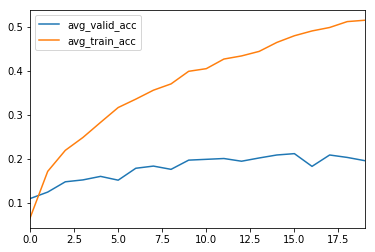

In [54]:
pd.DataFrame(history, columns=["avg_train_loss", "avg_train_acc", "avg_valid_loss", "avg_valid_acc"])[["avg_valid_acc", "avg_train_acc"]].plot()

In [ ]:
def predict(model, test_image_name):
     
    transform = image_transforms['test']
 
    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
     
    test_image_tensor = transform(test_image)
 
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
     
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(1, dim=1)
        print("Output class :  ", idx_to_class[topclass.cpu().numpy()[0][0]])

In [ ]:
import torch
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

class CustomDatasetFromCSV(Dataset):
    def __init__(self, csv_path, transform=None):
        self.data = pd.read_csv(csv_path)
        self.labels = pd.get_dummies(self.data['emotion']).as_matrix()
        self.height = 48
        self.width = 48
        self.transform = transform

    def __getitem__(self, index):
        # This method should return only 1 sample and label 
        # (according to "index"), not the whole dataset
        # So probably something like this for you:
        pixel_sequence = self.data['pixels'][index]
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(self.width, self.height)
        face = cv2.resize(face.astype('uint8'), (self.width, self.height))
        label = self.labels[index]

        return face, label

    def __len__(self):
        return len(self.labels)


dataset = CustomDatasetFromCSV(my_path)
batch_size = 16
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

# Usage Example:
num_epochs = 10
for epoch in range(num_epochs):
    # Train:   
    for batch_index, (faces, labels) in enumerate(train_loader):
        # ...

In [ ]:
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
    """

    def __init__(self, dataset, indices=None, num_samples=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices
            
        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        dataset_type = type(dataset)
        if dataset_type is torchvision.datasets.MNIST:
            return dataset.train_labels[idx].item()
        elif dataset_type is torchvision.datasets.ImageFolder:
            return dataset.imgs[idx][1]
        else:
            raise NotImplementedError
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [ ]:

data_dir = "alien_pred"
input_shape = 224
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

#data transformation
data_transforms = {
   'train': transforms.Compose([
       transforms.CenterCrop(input_shape),
       transforms.ToTensor(),
       transforms.Normalize(mean, std)
   ]),
   'validation': transforms.Compose([
       transforms.CenterCrop(input_shape),
       transforms.ToTensor(),
       transforms.Normalize(mean, std)
   ]),
}

image_datasets = {
   x: datasets.ImageFolder(
       os.path.join(data_dir, x),
       transform=data_transforms[x]
   )
   for x in ['train', 'validation']
}

dataloaders = {
   x: torch.utils.data.DataLoader(
       image_datasets[x], batch_size=32,
       shuffle=True, num_workers=4
   )
   for x in ['train', 'validation']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}

print(dataset_sizes)
class_names = image_datasets['train'].classes








criterion = torch.nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(vgg_based.parameters(), lr=0.001, momentum=0.9)


def train_model(model, criterion, optimizer, num_epochs=25):
   since = time.time()

   for epoch in range(num_epochs):
       print('Epoch {}/{}'.format(epoch, num_epochs - 1))
       print('-' * 10)

       #set model to trainable
       # model.train()

       train_loss = 0

       # Iterate over data.
       for i, data in enumerate(dataloaders['train']):
           inputs , labels = data
           inputs = inputs.to(device)
           labels = labels.to(device)

           optimizer.zero_grad()
          
           with torch.set_grad_enabled(True):
               outputs  = model(inputs)
               loss = criterion(outputs, labels)

           loss.backward()
           optimizer.step()

           train_loss += loss.item() * inputs.size(0)

           print('{} Loss: {:.4f}'.format(
               'train', train_loss / dataset_sizes['train']))
          
   time_elapsed = time.time() - since
   print('Training complete in {:.0f}m {:.0f}s'.format(
       time_elapsed // 60, time_elapsed % 60))

   return model

def visualize_model(model, num_images=6):
   was_training = model.training
   model.eval()
   images_so_far = 0
   fig = plt.figure()

   with torch.no_grad():
       for i, (inputs, labels) in enumerate(dataloaders['validation']):
           inputs = inputs.to(device)
           labels = labels.to(device)

           outputs = model(inputs)
           _, preds = torch.max(outputs, 1)

           for j in range(inputs.size()[0]):
               images_so_far += 1
               ax = plt.subplot(num_images//2, 2, images_so_far)
               ax.axis('off')
               ax.set_title('predicted: {} truth: {}'.format(class_names[preds[j]], class_names[labels[j]]))
               img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
               img = std * img + mean
               ax.imshow(img)

               if images_so_far == num_images:
                   model.train(mode=was_training)
                   return
       model.train(mode=was_training)
    
vgg_based = train_model(vgg_based, criterion, optimizer_ft, num_epochs=25)

visualize_model(vgg_based)